In [25]:
import numpy as np
from scipy.signal import butter, lfilter
from Code.Tutorial.dsp import load_demo
import matplotlib.pyplot as plt
import scipy

In [24]:

def plot_noise_signal(original_signal, noisy_signal, title_name):
    plt.figure()
    plt.plot(noisy_signal, label='Noisy Signal')
    plt.plot(original_signal, label='Original Signal')
    plt.ylabel('Amplitude')
    plt.xlabel('Time')
    plt.title(title_name)
    plt.legend()
    plt.show()


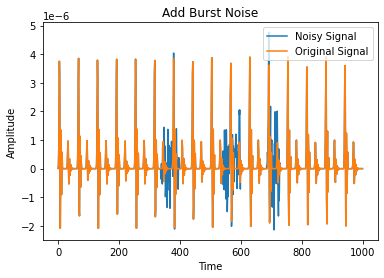

In [37]:
def add_burst_noise(
        signal, noise_amplitude=0.3, burst_num_max=1, burst_durations=[10, 100], show=False
):
    """
    Add burst noise to a signal.

    Parameters:
    signal : array-like
        The input signal to which burst noise will be added.
    noise_amplitude : float, optional
        The amplitude of the burst noise.
    burst_num_max : int, optional
        The maximum number of burst noise events to add.
    burst_durations : list, optional
        A list containing the minimum and maximum durations (in samples) of burst noise events.
    burst_intervals : list, optional
        A list containing the minimum and maximum intervals (in samples) between burst noise events.
    show : bool, optional
        Whether to display a plot of the noisy signal.

    Returns:
    noisy_signal : array-like
        An array containing the values of the signal with added burst noise.
    """
    # Get the length of the input signal
    signal_length = len(signal)

    # Initialize an array to store the burst noise
    _noise = np.zeros(signal_length)

    # Calculate the standard deviation of the input signal
    signal_sd = np.std(signal, ddof=1)

    # Calculate the amplitude of the burst noise to be added
    amp = noise_amplitude * signal_sd

    # Generate burst noise events based on specified parameters
    for _ in range(burst_num_max):
        # Initialize the starting point for burst noise events
        burst_start = np.random.randint(0, (signal_length - burst_durations[1] + 1))
        burst_duration = np.random.randint(burst_durations[0], burst_durations[1])
        burst_end = burst_start + burst_duration

        if burst_end >= signal_length:
            burst_end = signal_length

        _noise[burst_start: burst_end] += np.random.normal(0, amp, size=burst_end-burst_start)

    # Add the burst noise to the input signal
    noisy_signal = _noise + signal

    if show:
        # If requested, plot the original and noisy signals
        plot_noise_signal(signal, noisy_signal, 'Add Burst Noise')

    return noisy_signal

signal, _, _, _ = load_demo()
_ = add_burst_noise(signal, 1, 3, show=True)

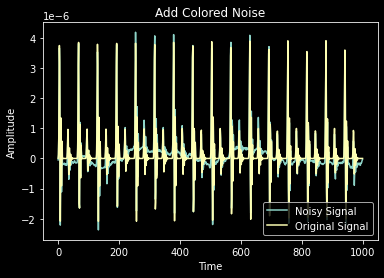

In [46]:
def add_colored_noise(signal, noise_amplitude=0.3, model='white', sampling_rate=100, duration=10, show=False):
    """
    Add colored noise to a given signal.

    Parameters:
        - signal (array): Input signal to which colored noise will be added.
        - noise_amplitude (float): Amplitude of the colored noise relative to the standard deviation of the input signal.
        - model (str): Type of colored noise to be added ('white', 'blue', 'brown', 'pink').
        - sampling_rate (int): Sampling rate of the signal.
        - duration (int): Duration of the generated noise in seconds.
        - show (bool): If True, plot the original and noisy signals.

    Returns:
        - array: Noisy signal with colored noise added.
    """

    # Define Power Spectral Density (PSD) function based on selected noise model
    if model == 'blue':
        def psd(f):
            return np.sqrt(f)
    elif model == 'brown':
        def psd(f):
            return 1 / np.where(f == 0, float('inf'), f)
    elif model == 'pink':
        def psd(f):
            return 1 / np.where(f == 0, float('inf'), np.sqrt(f))
    else:
        def psd(f):
            return 1

    # Calculate noise amplitude based on the standard deviation of the input signal
    noise_amplitude = np.std(signal) * noise_amplitude

    # Generate white noise in the frequency domain
    n_samples = sampling_rate * duration
    white_noise = np.random.randn(n_samples) * noise_amplitude
    X_white = np.fft.rfft(white_noise)

    # Calculate Power Spectral Density (PSD) of the noise
    S = psd(np.fft.rfftfreq(n_samples))

    # Normalize PSD
    S = S / np.sqrt(np.mean(S**2))

    # Shape white noise to match the desired PSD
    X_shaped = X_white * S

    # Transform back to time domain to get colored noise
    colored_noise = np.fft.irfft(X_shaped)

    # Add colored noise to the original signal
    noisy_signal = signal + colored_noise

    if show:
        # If requested, plot the original and noisy signals
        plot_noise_signal(signal, noisy_signal, 'Add Colored Noise')

    return noisy_signal


signal, _, _, _ = load_demo()
_ = add_colored_noise(signal, 0.3, 'brown', show=True)


In [48]:
def add_powerline_noise(
        signal, sampling_rate=100, duration=10, powerline_frequency=50, powerline_amplitude=0.1, show=False
):
    """
    Add powerline noise (mains hum) to a signal.

    Parameters:
    signal : array-like
        The input signal to which powerline noise will be added.
    sampling_rate : int, optional
        The sampling rate of the audio signal.
    duration : float, optional
        Duration of the powerline noise signal in seconds.
    powerline_frequency : float, optional
        Frequency of the powerline (mains) noise in Hertz.
    powerline_amplitude : float, optional
        Amplitude of the powerline noise.
    show : bool, optional
        Whether to display a plot of the noisy signal.

    Returns:
    noisy_signal : array-like
        An array containing the values of the signal with added powerline noise.
    """
    nyquist = sampling_rate * 0.4

    # Check if the specified powerline frequency is above the Nyquist frequency
    if powerline_frequency > nyquist:
        print(
            f"Skipping requested noise frequency of {powerline_frequency} Hz since it cannot be resolved at "
            f"the sampling rate of {sampling_rate} Hz. Please increase sampling rate to {sampling_rate * 2.5} Hz or choose "
            f"frequencies smaller than or equal to {nyquist} Hz."
        )
        return np.zeros(len(signal))

    # Calculate the standard deviation of the input signal
    signal_sd = np.std(signal, ddof=1)

    # Generate the powerline noise as a sine wave
    powerline_noise = sine_wave(duration=duration, sampling_rate=sampling_rate, amplitude=1, frequency=powerline_frequency, phase=0)


    # Scale the amplitude of the powerline noise
    powerline_amplitude *= signal_sd
    powerline_noise *= powerline_amplitude

    # Add the powerline noise to the input signal
    noisy_signal = powerline_noise + signal

    if show:
        # If requested, plot the original and noisy signals
        plot_noise_signal(signal, noisy_signal, 'Add Powerline Noise')

    return noisy_signal

from dsp import sine_wave
signal, _, _, _ = load_demo()
_ = add_powerline_noise(signal,show=True)

Skipping requested noise frequency of 50 Hz since it cannot be resolved at the sampling rate of 100 Hz. Please increase sampling rate to 250.0 Hz or choose frequencies smaller than or equal to 40.0 Hz.


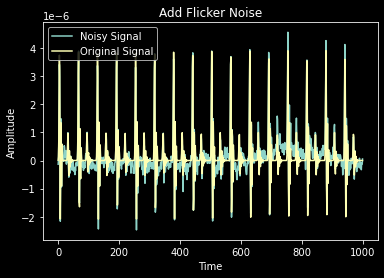

In [50]:
def add_flicker_noise(
        signal, noise_amplitude=0.3, sampling_rate=100, duration=10, show=False
):
    """
    Add flicker (1/f) noise to a signal.

    Parameters:
    signal : array-like
        The input signal to which flicker noise will be added.
    noise_amplitude : float, optional
        The amplitude of the burst noise.
    sampling_rate : int, optional
        The sampling rate of the audio signal.
    duration : float, optional
        Duration of the flicker noise signal in seconds.
    magnitude : float, optional
        Magnitude of the flicker noise.
    noise_exponent : float, optional
        Exponent determining the slope of the spectral density.
    show : bool, optional
        Whether to display a plot of the noisy signal.

    Returns:
    noisy_signal : array-like
        An array containing the values of the signal with added flicker noise.
    """
    def psd(f):
        return 1 / np.where(f == 0, float('inf'), np.sqrt(f))

    # Calculate noise amplitude based on the standard deviation of the input signal
    noise_amplitude = np.std(signal) * noise_amplitude

    # Generate white noise in the frequency domain
    n_samples = sampling_rate * duration
    white_noise = np.random.randn(n_samples) * noise_amplitude
    X_white = np.fft.rfft(white_noise)

    # Calculate Power Spectral Density (PSD) of the noise
    S = psd(np.fft.rfftfreq(n_samples))

    # Normalize PSD
    S = S / np.sqrt(np.mean(S**2))

    # Shape white noise to match the desired PSD
    X_shaped = X_white * S

    # Transform back to time domain to get colored noise
    colored_noise = np.fft.irfft(X_shaped)

    # Add colored noise to the original signal
    noisy_signal = signal + colored_noise

    if show:
        # If requested, plot the original and noisy signals
        plot_noise_signal(signal, noisy_signal, 'Add Flicker Noise')

    return noisy_signal


signal, _, _, _ = load_demo()
_ = add_flicker_noise(signal,show=True)

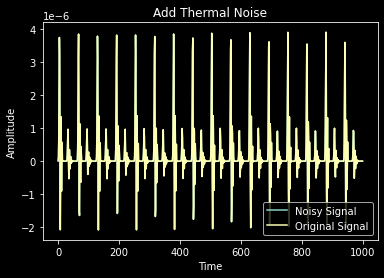

In [56]:
def add_thermal_noise(
        signal, noise_amplitude=0.3, sampling_rate=100, duration=10, Temperature=100, show=False
):
    """
    Add thermal noise to a signal.

    Parameters:
    signal : array-like
        The input signal to which thermal noise will be added.
    noise_amplitude : float, optional
        The amplitude of the burst noise.
    sampling_rate : int, optional
        The sampling rate of the audio signal.
    duration : float, optional
        Duration of the thermal noise signal in seconds.
    Temperature : float, optional
        Temperature in Kelvin, used to calculate thermal noise.
    show : bool, optional
        Whether to display a plot of the noisy signal.

    Returns:
    noisy_signal : array-like
        An array containing the values of the signal with added thermal noise.
    """
    num_samples = int(sampling_rate * duration)
    frequency_range = np.fft.fftfreq(num_samples)[1: num_samples // 2]

    # Calculate spectral density based on temperature
    k = 1.38e-23  # Boltzmann constant
    _spectral_density = k * Temperature / 2

    # Generate random phases for each frequency component
    random_phases = np.random.uniform(0, 2 * np.pi, len(frequency_range))

    # Combine magnitude and phases to form the complex spectrum
    spectrum = np.sqrt(_spectral_density) * np.exp(1j * random_phases)

    # Perform inverse FFT to convert complex spectrum to time-domain signal
    _thermal_noise = np.fft.irfft(spectrum, n=num_samples)

    # Scale the thermal noise to achieve the desired maximum amplitude
    _thermal_noise *= np.max(signal) * noise_amplitude

    # Add the thermal noise to the input signal
    noisy_signal = _thermal_noise + signal

    if show:
        # If requested, plot the original and noisy signals
        plot_noise_signal(signal, noisy_signal, 'Add Thermal Noise')

    return noisy_signal


signal, _, _, _ = load_demo()
_ = add_thermal_noise(signal, noise_amplitude=3,show=True)